## Applying PCA to reduce the dimensionality of data 

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [2]:
symbols = ['AAPL', 'MSFT','FB', 'AMZN', 'JNJ','XOM','BRK.B','JPM','GOOGL','GOOG']

In [3]:
def get_data(symbols, start_dt, end_dt):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=pd.date_range(start_dt,end_dt))
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')
    for symbol in symbols:
        df_temp = pd.DataFrame(web.DataReader(symbol, 'google', start_dt, end_dt)['Close']).rename(columns={'Close': symbol})
        df = df.join(df_temp)
    df = df.dropna(axis=0, how='all')
    return df

In [4]:
import time
data = get_data(symbols, '2016-7-28', time.strftime("%d/%m/%Y"))
# time.strftime("%d/%m/%Y")

In [5]:
data.head()

,SPY,AAPL,MSFT,FB,AMZN,JNJ,XOM,BRK.B,JPM,GOOGL,GOOG
2016-07-28,216.77,104.34,56.21,125.00,752.61,124.46,90.20,144.42,64.10,765.84,745.91
2016-07-29,217.12,104.21,56.68,123.94,758.81,125.23,88.95,144.27,63.97,791.34,768.79
2016-08-01,216.94,106.05,56.58,124.31,767.74,125.40,85.86,143.93,63.80,800.94,772.88
2016-08-02,215.55,104.48,56.58,123.09,760.58,124.85,87.04,143.31,63.65,800.12,771.07
2016-08-03,216.18,105.79,56.97,122.51,754.64,123.90,87.49,143.63,64.66,798.92,773.18


In [6]:
index = pd.DataFrame(data['SPY'])
data = data.drop('SPY', 1)

In [8]:
print(index.head())
data.head()

               SPY
2016-07-28  216.77
2016-07-29  217.12
2016-08-01  216.94
2016-08-02  215.55
2016-08-03  216.18


,AAPL,MSFT,FB,AMZN,JNJ,XOM,BRK.B,JPM,GOOGL,GOOG
2016-07-28,104.34,56.21,125.00,752.61,124.46,90.20,144.42,64.10,765.84,745.91
2016-07-29,104.21,56.68,123.94,758.81,125.23,88.95,144.27,63.97,791.34,768.79
2016-08-01,106.05,56.58,124.31,767.74,125.40,85.86,143.93,63.80,800.94,772.88
2016-08-02,104.48,56.58,123.09,760.58,124.85,87.04,143.31,63.65,800.12,771.07
2016-08-03,105.79,56.97,122.51,754.64,123.90,87.49,143.63,64.66,798.92,773.18


In [9]:
scale_function = lambda x: (x - x.mean()) / x.std()

In [10]:
scaled_data = data.apply(scale_function)
pca = KernelPCA().fit(scaled_data)

The importance or explanatory power of each component is given by its Eigenvalue. These are found in an attribute of the KernelPCA object. The analysis gives too many components. Therefore, let us only have a look at the first 10 components. The tenth component already has almost negligible influence:

In [11]:
pca.lambdas_[:10].round()

array([ 2148.,   270.,   100.,    68.,    21.,    15.,     9.,     6.,
           4.,     0.])

In [12]:
get_we = lambda x: x / x.sum()

In [13]:
get_we(pca.lambdas_)[:10].round(4)

array([ 0.8136,  0.1023,  0.0381,  0.0257,  0.0079,  0.0055,  0.0032,
        0.0022,  0.0014,  0.    ])

The first component already explains about 82% of the variability. The first five components
explain about 98% of the variability:

In [14]:
get_we(pca.lambdas_)[:5].sum()

0.98759391520989548

First, we have a PCA index with a single component only:

In [15]:
pca = KernelPCA(n_components=1).fit(scaled_data)

In [25]:
#index['PCA_1'] = pca.transform(scaled_data)
#index['PCA_1'] = 0
index['PCA_1'] = pca.transform(data)

In [26]:
index.head()

,SPY,PCA_1
2016-07-28,216.77,920.721526
2016-07-29,217.12,939.210348
2016-08-01,216.94,948.299330
2016-08-02,215.55,943.353135
2016-08-03,216.18,942.001746


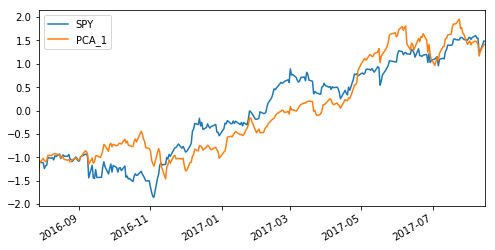

In [27]:
%matplotlib inline
index.apply(scale_function).plot(figsize=(8, 4))

Let us see if we can improve the results by adding more components. To this end, we need to calculate a weighted average from the single resulting components:

In [28]:
pca = KernelPCA(n_components = 5).fit(scaled_data)
pca_components = pca.transform(-data)
weights = get_we(pca.lambdas_)
index['PCA_5'] = np.dot(pca_components, weights)

In [29]:
get_we(pca.lambdas_)

array([ 0.82383762,  0.10359654,  0.03853237,  0.02600056,  0.00803291])

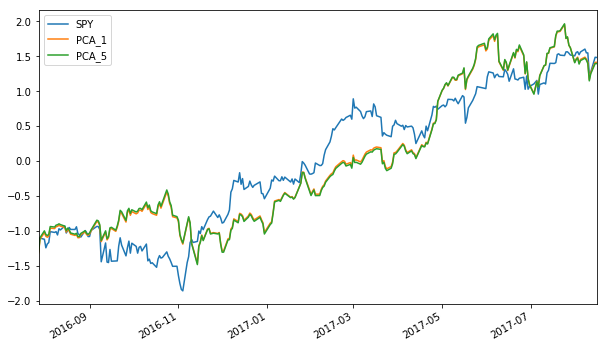

In [30]:
%matplotlib inline
index.apply(scale_function).plot(figsize=(10, 6), )

In [58]:
import matplotlib as mpl
mpl_dates = []
for i in range(len(data)):
    mpl_dates.append(mpl.dates.date2num(data.index[i]))
mpl_dates[1:5]

[736174.0, 736177.0, 736178.0, 736179.0]

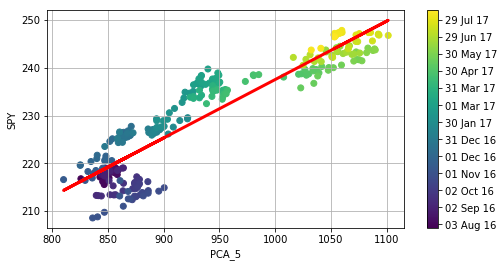

In [60]:
plt.figure(figsize=(8, 4))
plt.scatter(index['PCA_5'], index['SPY'], c=mpl_dates)
lin_reg = np.polyval(np.polyfit(index['PCA_5'], index['SPY'], 1),index['PCA_5'])
plt.plot(index['PCA_5'], lin_reg, 'r', lw=3)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('SPY')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=30),format=mpl.dates.DateFormatter('%d %b %y'))